### esempio di lettura di un run di dati (6765) e uno di piedistalli (6766)


In [3]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy
import time
import pandas as pd

lettura info file dati:

In [21]:
df = cy.run_info_logbook(run=6061, sql=True, verbose=False)
df

,run_number,run_description,start_time,exposure_sec,GEM3_V,GEM2_V,GEM1_V,T2_V,T1_V,DRIFT_V,...,PMT4_V,HV_STATE,stop_time,number_of_events,storage_local_status,storage_cloud_status,storage_tape_status,file_size,file_checksum,file_s3_tag
5508,6061,"S003:DATA:BKG, with pmt Trg: LVL2, 2mV thr, ve...",2022-12-03 07:24:11,0.3,420,420,420,500,500,960,...,770,1,2022-12-03 07:28:45,402.0,1,1,1,1668671789,6b820b7807bbc5f59dac3a418aaa0d37,LNGS


In [5]:
df.GEM3_V.values


array([420])

lettura file dati 

In [6]:

mfile = cy.open_mid(run=6061, path='/s3/cygno-data/', cloud=False, tag='LNGS', verbose=False)

for event in mfile:
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
    print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
    print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

    for bank_name, bank in event.banks.items():
        if bank_name=='DGH0': # PMTs wavform 
            header = cy.daq_dgz2header(bank)
            print (header)
            waveform = cy.daq_dgz2array(event.banks['DIG0'], header)
        if bank_name=='CAM0': # CAM image
            image, _, _ = cy.daq_cam2array(bank) # matrice delle imagine

        if bank_name=='INPT': # SLOW channels array
            slow = cy.daq_slow2array(bank)
    if event.header.serial_number == 2: 
        break

Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1670048651 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-12-03 06:24:11, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1670048651 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-12-03 06:24:11, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1670048651 containing banks DMND, MSRD
2022-12-03 06:24:11, banks DMND, MSRD
Event # 0 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1670048652 containing banks DIG0, DGH0, CAM0
2022-12-03 06:24:12, banks DIG0, DGH0, CAM0
(35, 32, 1024)
Event # 0 of type ID 7 contains banks TCAM
Received event with timestamp 1670048653 containing banks TCAM
2022-12-03 06:24:13, banks TCAM
Event # 1 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with ti

legge le waveforms (fino alla 5 perche' 5 ne acquisimo) e ne fa un plot

fa il plot dell'ultima imagine aperta (matrice image)

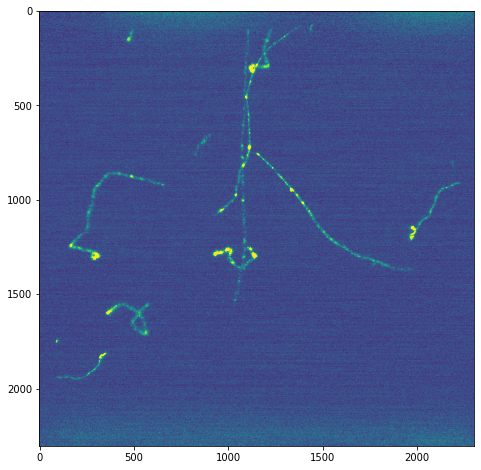

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(image, vmin=95, vmax=120)
plt.show()

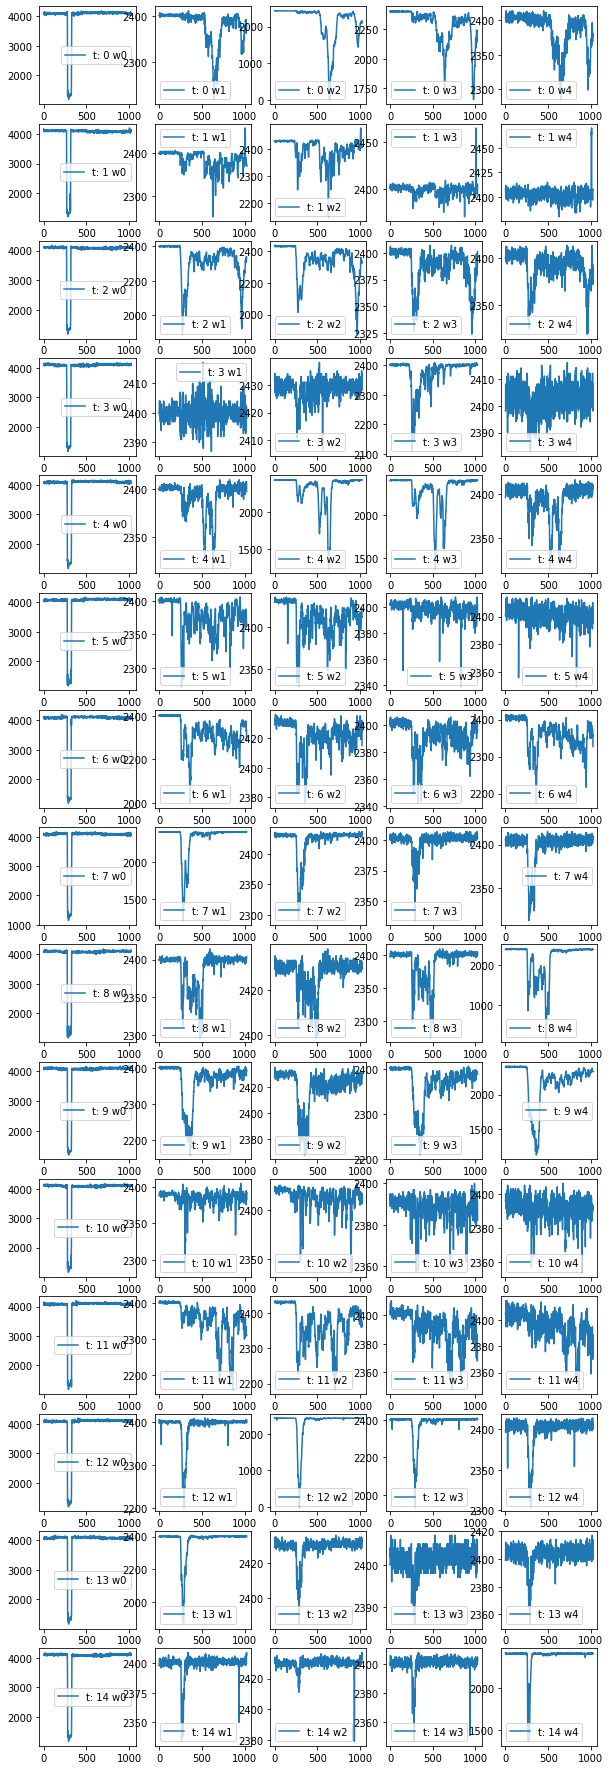

In [20]:
number_of_w_readed = 5
fig, ax = plt.subplots(header[0], number_of_w_readed, figsize=(10, header[1]))
for t in range(0, header[0]):
    offset = t*header[1]
    for w in range(0, number_of_w_readed):
        ax[t,w].plot(np.linspace(0, header[2], header[2]), waveform[offset], label="t: {:d} w{:d}".format(t,w))
        ax[t,w].legend()
        #ax[t,w].set_title("trigger: {:d} waveform: {:d}".format(t,w), fontsize='small')
        offset+=1

plt.show()

stampa dal db sql le informazioni sul rum di pieditalli

In [6]:
df = cy.run_info_logbook(run=6766, sql=True, verbose=False)
df

,run_number,run_description,start_time,exposure_sec,GEM3_V,GEM2_V,GEM1_V,T2_V,T1_V,DRIFT_V,...,PMT4_V,HV_STATE,stop_time,number_of_events,storage_local_status,storage_cloud_status,storage_tape_status,file_size,file_checksum,file_s3_tag
6208,6766,"S003:PED:BKG, no PMT, flux 10l/h",2022-12-06 06:42:29,0.3,420,420,420,500,500,960,...,770,0,2022-12-06 06:43:23,101.0,1,1,1,364629681,7518b64a535ab9f4a3ceddabc7a71cf0,LNGS


In [15]:
m_image, s_image = cy.ped_mid(run=6060, path_file='/s3/cygno-data/', path_ped='/tmp/', tag = 'LNGS', 
            cloud=False, verbose=True)

Welcome to JupyROOT 6.24/08
RELOAD maen file: /tmp/mean_Run06060 sigma file: /tmp/sigma_Run06060


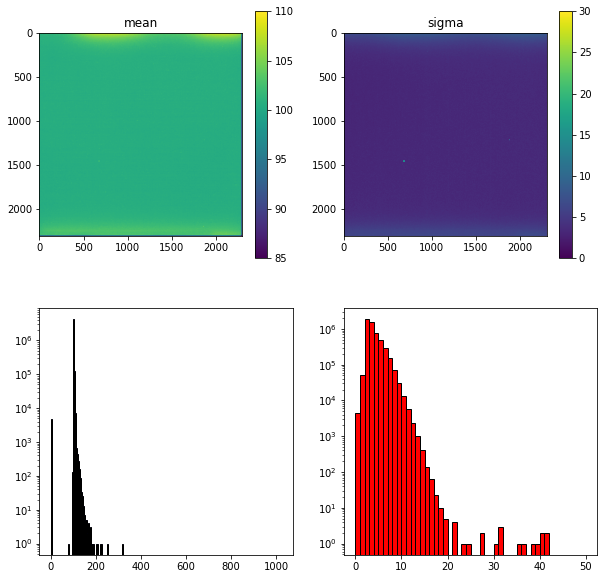

In [17]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
im = ax[0, 0].imshow(m_image, vmin=85,vmax=110)
fig.colorbar(im, ax=ax[0, 0])
ax[0, 0].set_title("mean")
ax[0, 1].set_title("sigma")
im = ax[0, 1].imshow(s_image, vmin=0,vmax=30)
fig.colorbar(im, ax=ax[0,1])
ax[1, 0].hist(m_image.ravel(), bins=256, range=(0.0, 1024.0), fc='b', ec='k')
ax[1, 1].hist(s_image.ravel(), bins=50, range=(0.0, 50.0), fc='r', ec='k')
ax[1,0].set_yscale("log")
ax[1,1].set_yscale("log")

plt.show()

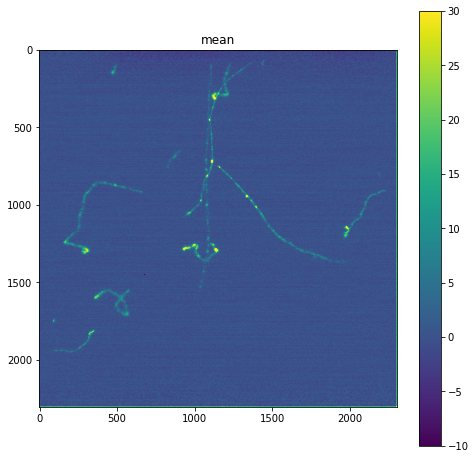

In [19]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(image-m_image, vmin=-10,vmax=30)
fig.colorbar(im, ax=ax)
ax.set_title("mean")
plt.show()